# GRU MODEL PREDICTION CLOSE PRICE

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Bidirectional
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [3]:
train_df = pd.read_csv('Train.csv')
test_df = pd.read_csv('Test.csv')

In [4]:
train_df ['date_time'] = pd.to_datetime(train_df['date_time'])
test_df ['date_time'] = pd.to_datetime(test_df['date_time'])

In [5]:
train_df['sell_price'] = train_df['sell_price'].astype(float)
test_df ['sell_price'] = test_df['sell_price'].astype(float)

In [6]:
train_df = train_df.dropna(subset=['sell_price'])
test_df = test_df.dropna(subset=['sell_price'])

In [7]:
scaler = MinMaxScaler(feature_range=(0,1))
train_df['sell_price_scaled'] = scaler.fit_transform(train_df[['sell_price']])
test_df['sell_price_scaled'] = scaler.transform(test_df[['sell_price']])

In [8]:
print("Checking for NaNs after scaling:")
print(train_df['sell_price_scaled'].isnull().sum())
print(test_df['sell_price_scaled'].isnull().sum())

Checking for NaNs after scaling:
0
0


In [9]:
def create_sequences (data , date_time = 1):
    sequences = []
    label = []
    for i in range(len(data)-date_time):
        sequences.append(data[i:i + date_time])
        label.append(data[i+date_time])
    return np.array(sequences) , np.array(label)



In [10]:
date_time = 10
X_train, y_train = create_sequences(train_df['sell_price_scaled'].values,date_time)
X_test , y_test = create_sequences(test_df['sell_price_scaled'].values,date_time)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [11]:
final = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=X_train.shape[-2:]),
    Bidirectional(tf.keras.layers.GRU(128, activation='relu', return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    Bidirectional(tf.keras.layers.GRU(64, activation='relu', return_sequences=False)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1) 
])

In [12]:
final.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.003), loss='mae')


In [13]:
final.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 10, 256)        │       100,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       123,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 228,417 (892.25 KB)

 Trainable params: 228,417 (892.25 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
]

In [15]:
history_final = final.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), callbacks=callbacks_list)


Epoch 1/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 38s 67ms/step - loss: 0.0715 - val_loss: 0.0191 - learning_rate: 0.0030
Epoch 2/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 0.0267 - val_loss: 0.0214 - learning_rate: 0.0030
Epoch 3/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 0.0254 - val_loss: 0.0177 - learning_rate: 0.0030
Epoch 4/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0228 - val_loss: 0.0337 - learning_rate: 0.0030
Epoch 5/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 0.0213 - val_loss: 0.0504 - learning_rate: 0.0030
Epoch 6/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0210 - val_loss: 0.0490 - learning_rate: 0.0030
Epoch 7/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0194 - val_loss: 0.0699 - learning_rate: 0.0030
Epoch 8/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0204 - val_loss: 0.0193 - learning_rate: 0.0030
Epoch 9/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.0173 - val_loss: 0.0267 - learning_rate: 0.001

In [16]:
predicted_sell_price_scaled = final.predict(X_test)
predicted_sell_price = scaler.inverse_transform(predicted_sell_price_scaled)


17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step


In [17]:
if np.isnan(predicted_sell_price).any() or np.isnan(test_df['sell_price'][date_time:]).any():
    print("Warning: Predicted values contain NaNs. Please check your data and model.")
else:
    # Calculate MAE
    mae = mean_absolute_error(test_df['sell_price'][date_time:], predicted_sell_price)
    print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 1128.1371255189115


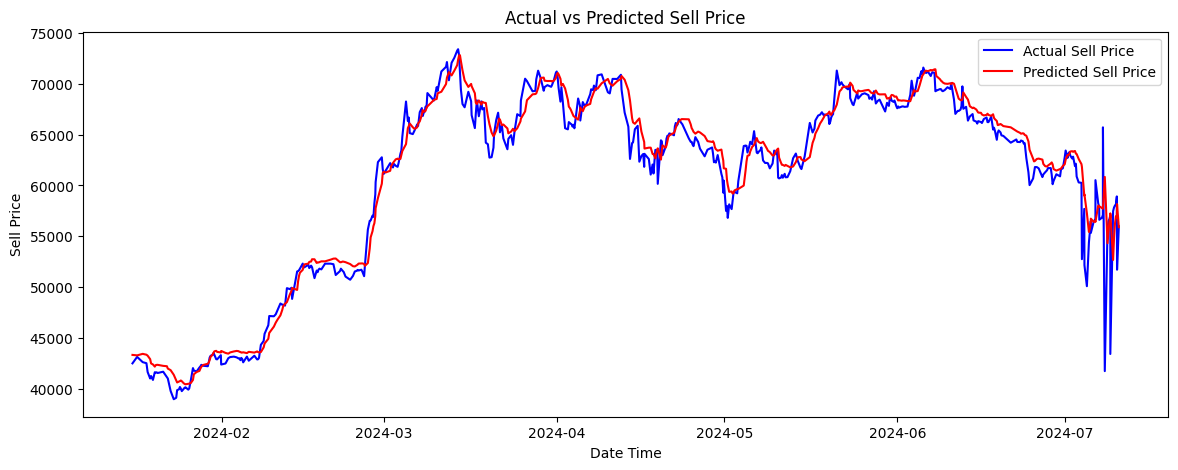

In [18]:
plt.figure(figsize=(14, 5))
plt.plot(test_df['date_time'][date_time:], test_df['sell_price'][date_time:], color='blue', label='Actual Sell Price')
plt.plot(test_df['date_time'][date_time:], predicted_sell_price, color='red', label='Predicted Sell Price')
plt.title('Actual vs Predicted Sell Price')
plt.xlabel('Date Time')
plt.ylabel('Sell Price')
plt.legend()
plt.show()

In [19]:
import pandas as pd
import numpy as np
import os
actual_sell_price = test_df['sell_price'][-len(predicted_sell_price):]
signals = np.where(actual_sell_price > predicted_sell_price.flatten(), 1, -1)
signals_df = pd.DataFrame({
    'GRU_Signals': signals
})
signals_df.to_csv('gru_signals.csv', index=False, mode='a', header=not os.path.exists('gru_signals.csv'))


In [20]:
final.save_weights('model.weights.h5')
